# Digit recognizer using PyTorch

## By Marawan Abdelrahman

__Steps__:
1. Preparing the dataset
2. Train and validate
3. Making Prediction


### 1. Preparing the dataset

#### Importing Libraries necessary

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image


#### Importing the digits from csv file

In [2]:
train = pd.read_csv("digit-recognizer/train.csv", dtype=np.float32)
test = pd.read_csv("digit-recognizer/test.csv", dtype=np.float32)
order = pd.read_csv("digit-recognizer/sample_submission.csv")
train.label.head()

0    1.0
1    0.0
2    1.0
3    4.0
4    0.0
Name: label, dtype: float32

#### Splitting between the image and their labels

In [3]:
targets_np = train.label.values
features_np = train.loc[:, train.columns != 'label'].values/255

features_train, features_test, target_train, target_test = train_test_split(features_np, targets_np, test_size=0.2, random_state=42)

In [4]:
#convert to tensors
featuresTrain = torch.from_numpy(features_train) 
targetsTrain = torch.from_numpy(target_train).type(torch.LongTensor)

In [5]:
#convert to tensors
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(target_test).type(torch.LongTensor)

#### specifing the batch size for train and validation data

In [6]:
batch_size = 256

train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
val = torch.utils.data.TensorDataset(featuresTest,targetsTest)

trainloaders = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
valloaders = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)

#### Visualize a column of pixels

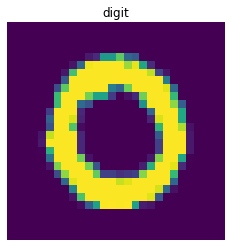

In [7]:
def visualize_image(data, index, pred=False, val=0):
    plt.imshow(data[index].reshape(28,28))
    plt.axis("off")
    plt.title("digit")
    plt.show()
visualize_image(features_np, 1)

### 2. Train and validate

#### Creating a DL model of 784 inputs, 10 outputs and 1 hidden layer 

In [8]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                     nn.LogSoftmax(dim=1))
critaion = nn.NLLLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)


#### Train the model with training data and vaildate it

In [9]:
epochs = 12
steps = 0 
i = 0
print_every = 100 
running_loss = 0


for epoch in range(epochs):
    for image, label in trainloaders:
        steps += 1 
        optimizer.zero_grad() 
        ps = model.forward(image) 
        loss = critaion(ps, label) 
        loss.backward() 
        optimizer.step() 
        running_loss += loss.item() 
        if steps % print_every == 0: 
            test_loss = 0
            accu = 0
            model.eval() 
            with torch.no_grad():
                model.eval()
                for image, label in valloaders:
                     
                
                    lgsoftmx = model.forward(image)
                    
                    batch_loss = critaion(lgsoftmx,label)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(lgsoftmx) 
                    top_p, top_class = ps.topk(1, dim=1)
                    equally = top_class == label.view(*top_class.shape) 
                    accu += torch.mean(equally.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. " 
                  f"validation loss: {test_loss/len(valloaders):.3f}.. "
                  f"validation accuracy: {accu/len(valloaders):.3f}") 
            running_loss = 0
            model.train() 
        

Epoch 1/12.. Train loss: 0.549.. validation loss: 0.292.. validation accuracy: 0.913
Epoch 2/12.. Train loss: 0.229.. validation loss: 0.208.. validation accuracy: 0.939
Epoch 3/12.. Train loss: 0.173.. validation loss: 0.163.. validation accuracy: 0.952
Epoch 4/12.. Train loss: 0.130.. validation loss: 0.150.. validation accuracy: 0.953
Epoch 4/12.. Train loss: 0.103.. validation loss: 0.128.. validation accuracy: 0.963
Epoch 5/12.. Train loss: 0.083.. validation loss: 0.124.. validation accuracy: 0.964
Epoch 6/12.. Train loss: 0.073.. validation loss: 0.123.. validation accuracy: 0.964
Epoch 7/12.. Train loss: 0.061.. validation loss: 0.117.. validation accuracy: 0.965
Epoch 7/12.. Train loss: 0.050.. validation loss: 0.122.. validation accuracy: 0.964
Epoch 8/12.. Train loss: 0.046.. validation loss: 0.114.. validation accuracy: 0.967
Epoch 9/12.. Train loss: 0.039.. validation loss: 0.115.. validation accuracy: 0.969
Epoch 10/12.. Train loss: 0.038.. validation loss: 0.103.. valida

#### function for visualizing the outputs of the model and the input digit

In [10]:
def view_classify(img, ps):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

#### A function for inputing the digit in the model and output the values of the prediction

tensor([[7.7754e-12, 9.9964e-01, 5.7376e-09, 4.0801e-06, 5.8806e-08, 2.9389e-07,
         6.3076e-10, 3.5153e-04, 3.0038e-06, 5.9206e-06]])


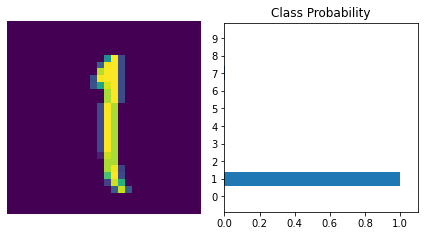

In [11]:
def make_prediction(data):
    images, labels = next(iter(data))

    img = images[42].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    print(ps)
    view_classify(img.view(1, 28, 28), ps)
make_prediction(valloaders)

### 3. Making Prediction

#### normalize the pixel values

In [12]:
prediction = test.values/255
test_t = torch.from_numpy(prediction)

#### Adding a fake label to the digit to be used only in dataloader 

In [13]:
fake_label = np.zeros(prediction.shape)
fake_label = torch.from_numpy(fake_label)

#### Creating dataloader of digits and fake labels

In [14]:
predict_t = torch.utils.data.TensorDataset(test_t, fake_label)

predict_loader = torch.utils.data.DataLoader(predict_t, batch_size = batch_size, shuffle = True)

#### making prediction  

tensor([[3.4969e-11, 2.1423e-10, 4.3271e-09, 3.7597e-09, 1.1728e-12, 4.8053e-09,
         1.0000e+00, 1.8441e-13, 2.1101e-09, 2.5189e-19]])


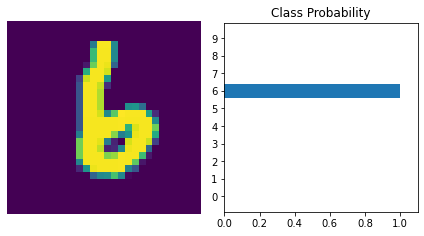

In [15]:
make_prediction(predict_loader)


### Thanks 